In [26]:
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
matplotlib.rc("font", size=18)
from astropy.cosmology import FlatLambdaCDM
import power_spectrum  #FOR THE COMPUTATION OF THE AUTO POWER SPECTRUM AND CROSS POWER SPECTRUM
from astropy.wcs import WCS
import astropy.io.fits as pyfits
from astropy import wcs
import numpy.ma as ma
from scipy import ndimage
from numpy import fft
import math

In [2]:
arcsec2rad = math.pi/(180.0*3600.0)
ster2sqdeg = 3282.8
ster2sqarcmin = ster2sqdeg * 3600.0
ster2sqarcsec = ster2sqdeg * 3600.0 * 3600.0

### CONVERSION FROM ANGULAR DISTANCE TO PROJECTED DISTANCE

In [3]:
if __name__ == '__main__':    
    
    cosmo_flat = FlatLambdaCDM(H0=70.0, Om0=0.3, Tcmb0=2.7255)
    z=0.308
    scale = cosmo_flat.kpc_proper_per_arcmin(z)
    #print(scale.value/60)
    ang_r=(scale.value/60)
    print('Kpc/arcsec at z=0.308',ang_r)

Kpc/arcsec at z=0.308 4.5356240737371705


### OPEN IMAGES

In [4]:
hdu_list_mass=pyfits.open('meanmass.fits')
header_mass = pyfits.getheader('meanmass.fits')

data_mass=hdu_list_mass[0].data

print(header_mass)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H EQUINOX =                2000. / EQUINOX                                        RADECSYS= 'FK5     '           / RADECSYS                                       CTYPE1  = 'RA---TAN'           / CTYPE1                                         CRVAL1  =             3.586259 / CRVAL1                                         CRPIX1  =                500.5 / CRPIX1                                         CDELT1  = -0.000278055833611389 / CDELT1

In [5]:
#THE MASK IS USED IN THE X-RAY ANALYSIS, IT ALLOWS YOU TO MASK THE POINT SOURCES WHEN YOU ARE INTERESTED IN
#THE STUDY OF THE DIFFUSE GAS; IN THIS CASE YOU DON'T NEED IT, SO I DEFINE A MATRIX OF ONES, IN ORDER TO USE 
#THE SCRIPT power_spectrum.py WITHOUT CHANGING IT.
data_mask_chandra=np.ones((header_mass['NAXIS1'],header_mass['NAXIS2']),dtype=float)
print(data_mask_chandra.shape)

(1000, 1000)


In [6]:
#PIXEL SIZE IN ARCSEC
pixel=header_mass['CDELT2']*3600.0
print('pixel size in arcsec',pixel)

pixel size in arcsec 1.0010010010010004


In [7]:
#The 'meanmass.fits' is a surface density map (M_sun/kpc^2) in units of 10^12 M_sun
#To make it dimensionless you can devide by Sigma_crit=(c^2/4piG)*D_os*D_ol/D_ls, the critical surface mass 
#density 
ecf_mass=1e12
sigma_crit=2.35e09

data_mass=data_mass*ecf_mass/sigma_crit
average_mass=np.average(data_mass)
print('average_mass',average_mass)

average_mass 1.4836724008494835


### FLUCTUATION FIELD

In [8]:
field_mass=data_mass-average_mass
#field_mass=(data_mass-average_mass)/average_mass #FLUCTUATION RELATIVE TO THE BACKGROUND MEAN DENSITY

### ANGULAR BINNING

In [9]:
# bin edges in arcsecs
#ADAPTIVE BINNING (they have been rearranged in order to optimize the ps errors; in addition, their separation 
#must be higher than, at least, 3 or 4 times the pixel size)

tet_1grid_old = np.append((0.1+10**(.065*np.arange(50))), 1533.0)
print(tet_1grid_old)
tet_1grid_new=np.zeros(24,dtype=float)
tet_1grid_new[0]=3.41131121e+00 
tet_1grid_new[1]=7.09841996e+00 
tet_1grid_new[2]=1.10647820e+01 
tet_1grid_new[3]=1.48910839e+01 
tet_1grid_new[4]=1.72790839e+01
tet_1grid_new[5:22]=tet_1grid_old[20:37]
tet_1grid_new[22]=3.98207171e+02 
tet_1grid_new[23]=1.53300000e+03
tet_1grid=np.zeros(24,dtype=float)
tet_1grid=tet_1grid_new
print(tet_1grid)

[1.10000000e+00 1.26144861e+00 1.44896288e+00 1.66675107e+00
 1.91970086e+00 2.21348904e+00 2.55470892e+00 2.95101827e+00
 3.41131121e+00 3.94591782e+00 4.56683592e+00 5.28800039e+00
 6.12559586e+00 7.09841996e+00 8.22830516e+00 9.54060876e+00
 1.10647820e+01 1.28350308e+01 1.48910839e+01 1.72790839e+01
 2.00526231e+01 2.32739465e+01 2.70153480e+01 3.13607937e+01
 3.64078055e+01 4.22696503e+01 4.90778819e+01 5.69852931e+01
 6.61693448e+01 7.68361489e+01 8.92250938e+01 1.03614217e+02
 1.20326443e+02 1.39736836e+02 1.62281010e+02 1.88464909e+02
 2.18876162e+02 2.54197271e+02 2.95220923e+02 3.42867787e+02
 3.98207171e+02 4.62481021e+02 5.37131796e+02 6.23834835e+02
 7.24535960e+02 8.41495142e+02 9.77337221e+02 1.13511082e+03
 1.31835674e+03 1.53118746e+03 1.53300000e+03]
[   3.41131121    7.09841996   11.064782     14.8910839    17.2790839
   20.05262315   23.2739465    27.01534804   31.36079367   36.40780548
   42.26965034   49.07788194   56.98529308   66.1693448    76.83614894
   89.225

### MASS POWER SPECTRUM

In [10]:
#COMPUTING THE AUTO POWER SPECTRUM
(k_p_mass, pairs_mass, amp_mass, power_mass, sig_p_mass) = \
power_spectrum.auto_power_obs ( field_mass, data_mask_chandra, \
                               tet_1grid, pixel, outfile = None, writefits = None )

theta_mass = 1/k_p_mass
q_p_mass = 2.0*np.pi*k_p_mass
q_rad_mass = q_p_mass/arcsec2rad
power_q_mass = power_mass*q_rad_mass**2/(2.0*math.pi) 
sig_p_q_mass = sig_p_mass*q_rad_mass**2/(2.0*math.pi)

FOV in steradian = 2.3551555563946764e-05
fraction of unmasked area = 1.0
k_minmax after binning = [0.29314241 0.14087642 0.09037684 0.06715428 0.05787344 0.04986879
 0.0429665  0.037016   0.03188695 0.02746664 0.02365764 0.02037578
 0.01754839 0.01511274 0.01301471 0.01120761 0.00965119 0.00831073
 0.00715631 0.00616215 0.00530603 0.00456879 0.00251126 0.00065232]
monotonically increasing k_minmax = [0.00065232 0.00251126 0.00456879 0.00530603 0.00616215 0.00715631
 0.00831073 0.00965119 0.01120761 0.01301471 0.01511274 0.01754839
 0.02037578 0.02365764 0.02746664 0.03188695 0.037016   0.0429665
 0.04986879 0.05787344 0.06715428 0.09037684 0.14087642 0.29314241]
y,x = [[0.       0.       0.       ... 0.       0.       0.      ]
 [0.000999 0.000999 0.000999 ... 0.000999 0.000999 0.000999]
 [0.001998 0.001998 0.001998 ... 0.001998 0.001998 0.001998]
 ...
 [0.996003 0.996003 0.996003 ... 0.996003 0.996003 0.996003]
 [0.997002 0.997002 0.997002 ... 0.997002 0.997002 0.997002]
 [0.998001 0

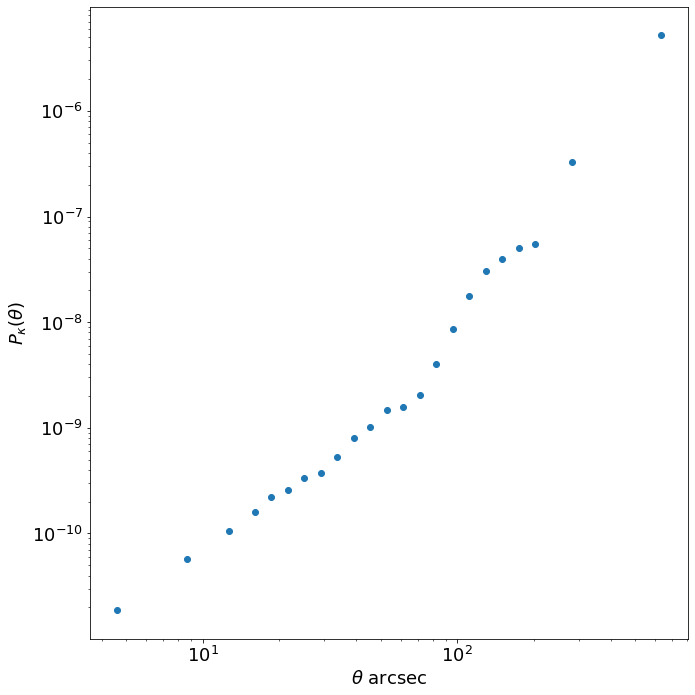

In [35]:
fig = plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
plt.plot(theta_mass, power_mass, 'o')
plt.xlabel(r'$\theta$ arcsec')
plt.ylabel(r'$P_\kappa(\theta) $')
plt.tight_layout()
plt.show()
#fig.savefig('abell2744_power_theta.jpeg')
#pylab.show()

/tmp/ipykernel_108720/2022114760.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mass.tight_layout()


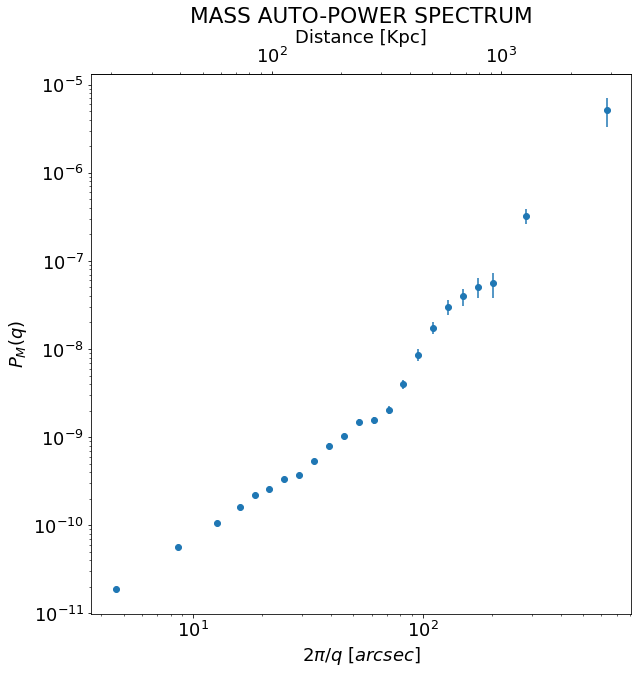

In [12]:
fig_mass = matplotlib.pyplot.figure( figsize=(10,10) )
ax = fig_mass.add_axes([0.18,0.16,0.75,0.75])
ax.errorbar(theta_mass, power_mass, yerr =sig_p_mass, color='C0', fmt='o')
fig_mass.tight_layout()
ax.set_xlabel(r'$2\pi/q$ $[arcsec]$')
ax.set_ylabel(r'$P_M(q) $')
ax.set_xscale('log')
ax.set_yscale('log')

def arcsec2dist(theta_ang):
    return (scale.value/60)*theta_ang

def dist2arcsec(theta_ang):
    return (theta_ang*60/(scale.value))

secax = ax.secondary_xaxis('top', functions=(arcsec2dist,dist2arcsec))
secax.set_xlabel('Distance [Kpc]')

ax.title.set_text('MASS AUTO-POWER SPECTRUM')

/tmp/ipykernel_108720/2415245714.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mass2.tight_layout()


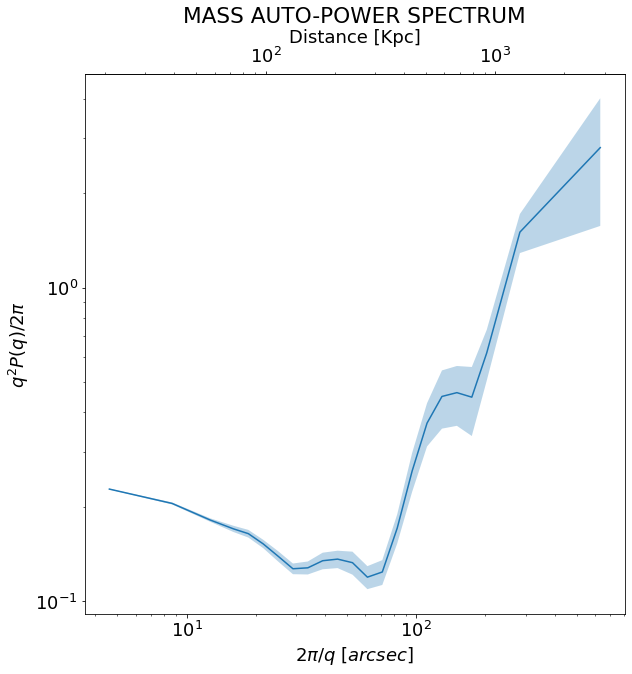

In [17]:
mass_smooth=ndimage.gaussian_filter1d(power_q_mass, sigma=0.8)

y1 = mass_smooth + sig_p_q_mass
y2 = mass_smooth - sig_p_q_mass

fig_mass2 = matplotlib.pyplot.figure( figsize=(10,10) )
ax = fig_mass2.add_axes([0.18,0.16,0.75,0.75])
ax.plot(theta_mass, mass_smooth, color='C0')
ax.fill_between(theta_mass, y1, y2,alpha=0.3)
#ax1.set_title('fill between y1 and y2')
#ax1.set_xlabel('x')
fig_mass2.tight_layout()
#fig8, axs = plt.subplots(1,2,figsize=(10,6))
#ax1.plot(theta, power_q_mass2, color='C0', label=r'CATS mass auto-power')
ax.set_xlabel(r'$2\pi/q$ $[arcsec]$')
ax.set_ylabel(r'$q^2P(q)/2\pi $')
ax.set_xscale('log')
ax.set_yscale('log')
#ax1.legend(loc='best')

secax = ax.secondary_xaxis('top', functions=(arcsec2dist,dist2arcsec))
secax.set_xlabel('Distance [Kpc]')

ax.title.set_text('MASS AUTO-POWER SPECTRUM')